In this assignment, you'll get hands-on experience coding and training Generative Adversarial Networks or GANs. We will implement a specific type of GAN designed to process images, called a Deep Convolutional GAN (DCGAN). We'll train the DCGAN to generate natural images from CIFAR10. Let's get started. 


A GAN is a generative model that has the following network structure:

![discriminator](https://drive.google.com/uc?export=view&id=19LkOTaowOrNhIKvjXWvO6qhFVUNZMF5Y)

A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and a network composed of transposed convolutions as the generator. To implement the DCGAN, we need to specify three things: 


1.   the Discriminator
2.   the Generator
3.   the training Procedure



## **Part 1: Implement the Discriminator of the DCGAN**

The discriminator in the DCGAN you will implement is a convolutional neural network with the following architecture:

![discriminator](https://drive.google.com/uc?export=view&id=1KrqS_AyjHIm7leVh58pjVRmnGx-le1vB)


1.   **Padding**: In each of the convolutional layers shown above, we downsample the spatial dimension of the input volume by a factor of 2. Given that we kernel size $K=5$ and stride $S=2$, what should the padding be? Write your answer below in the colab, and show your work (i.e. the formula you used to derived the padding.)
2.   **Implementation**: Implement the above architecture in the ```define_discriminator``` routine below and return the model.






## Answer

To get the padding, we can use the equation we learned in class:

$r = \frac {n + 2p - f}{s}  + 1$,

to get the padding p:

$p = \frac {s(r-1) + f - n} {2}$,

where `s = stride = 2`, `f = kernel size = 5`, `p = padding`, `r = resultant dimension = 16`, and `n = input image dimensions = 32`

to get the following:

$p = 2$


##Discriminator Implementation

To define the discriminator, we note the following things about its structure from lecture:

- We can apply Batch Normalization everywhere except the discriminator input
- We use LeakyReLU for the discriminator

To build the model, we simply followed the diagram provided above, where we applies four convolutions. The last convolution we generated a 2x2x256, then applied `Flatten()` and then a FC layer.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model_gan_path= "/content/gdrive/My Drive/DL/gan_train.hdf5"
model_g_path = "/content/gdrive/My Drive/DL/generator_train.hdf5"
model_d_path = "/content/gdrive/My Drive/DL/discriminator_train.hdf5"


In [ ]:
import tensorflow as tf
import tensorflow.random
import matplotlib.pyplot as plt
import os
import keras
from keras.models import save_model
from tensorflow.keras.models import load_model
import numpy as np


def define_discriminator(input_shape=(32,32,3)):
	
	kernel = 5
	stride = 2

	assert input_shape == (32,32,3)
 
	# create model
	model = keras.Sequential()

	# 1st conv
	model.add(keras.layers.Conv2D(filters=32,kernel_size=kernel,padding='same',strides=stride,input_shape=(32,32,3)))
	model.add(keras.layers.LeakyReLU(0.2))
	model.add(keras.layers.Dropout(0.25))
	model.add(keras.layers.BatchNormalization())
	# print(f"1st conv2d: output_shape: {model.output_shape}")

	# 2nd conv
	model.add(keras.layers.Conv2D(filters=64,kernel_size=kernel,padding='same',strides=stride))
	model.add(keras.layers.BatchNormalization())
	model.add(keras.layers.LeakyReLU(0.2))
	model.add(keras.layers.Dropout(0.25))
	# print(f"2nd conv2d: output_shape: {model.output_shape}")

	# 3rd conv
	model.add(keras.layers.Conv2D(filters=128,kernel_size=kernel,padding='same',strides=stride))
	model.add(keras.layers.BatchNormalization())
	model.add(keras.layers.LeakyReLU(0.2))
	model.add(keras.layers.Dropout(0.25))
	# print(f"3rd conv2d: output_shape: {model.output_shape}")
	
	# 4th convolution
	model.add(keras.layers.Conv2D(filters=256,kernel_size=kernel,padding='same',strides=stride))
	model.add(keras.layers.BatchNormalization())
	model.add(keras.layers.LeakyReLU(0.2))
 
	# FC layer
	model.add(keras.layers.Flatten())
 
	# output
	model.add(keras.layers.Dense(1 ,activation='sigmoid'))
 
	# define optimizer
	opt = keras.optimizers.Adam(learning_rate=3e-5, beta_1 = 0.45)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

	return model


## **Part 2: Implement the Generator**

Now, we will implement the generator of the DCGAN in ```define_generator```, which consists of a sequence of transpose convolutional layers that progressively upsample the input noise sample to generate a fake image. Since the training of the generator involves an end-to-end cost function involving both the generator and the discriminator, you should also define a combined GAN model in ``define_gan``. Note that the discriminator portion is frozen (setting ``trainable`` to ``False``) as the weights of the discriminator are not modified during the training of the generator. The generator has the following architecture:

![discriminator](https://drive.google.com/uc?export=view&id=18RwpQChvU1FLfnCEfMiJKsKklsOkDyTS)



##Generator Implementation

To create the generator, we followed the structure presented in class, where:

- We apply Batch Normalization on all layers except for the generator output
- We apply ReLU through the generator except at the output
- At the output, we apply a `tanh` activation


To implement the generator, we also followed the diagram above and played around with the ReLU values. Since the input has an `input_shape` of dimenstion `100`, we made a dense layer and reshaped it to a 4x4x128. Then, we followed the diagram, following the number of filters, kernel stride, and kernel size as specified above. 

For the GAN, we set the discriminator training to `False` because we need to train the discriminator separately. In the GAN, we generate a latent vector of dimension 100 and put it through the generator. Then, we used the output fake image as the input to the discriminator to get a decision. This decision and the original latent vector are used to create the GAN model, since we want an output decision and a model that takes in a latent vector.

In [ ]:
# define the standalone generator model
import tensorflow as tf
import tensorflow.random
import matplotlib.pyplot as plt
import os
import keras
from keras.models import save_model
from keras.models import model_from_json
import keras.initializers as initializers
import numpy as np

def define_generator(latent_dim=100):

    # create model   
    model = keras.Sequential()

    # reshape input to 4x4x128
    model.add(keras.layers.Dense(4*4*128, input_shape=(latent_dim,)))
    model.add(keras.layers.Reshape((4, 4, 128)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))
    # print(f"after linear and reshape: output_shape: {model.output_shape}")

    # 1st conv
    model.add(keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))
    # print(f"1st conv2d_transpose: output_shape: {model.output_shape}")
    
    # 2nd conv
    model.add(keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'))    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))
    # print(f"2nd conv2d_transpose: output_shape: {model.output_shape}")

    # 3rd conv
    model.add(keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))
    # print(f"3rd conv2d_transpose: output_shape: {model.output_shape}")

    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):

  # make weights in the discriminator not trainable
  d_model.trainable = False
  
  # Define your combined model here 
  x = keras.layers.Input(shape=(100,))
  img = g_model(x)
  decision = d_model(img)

  model = keras.models.Model(inputs=x,outputs=decision)
  model.compile(keras.optimizers.Adam(learning_rate=3e-4, beta_1 = 0.85), loss='binary_crossentropy', metrics=['binary_accuracy'])
  return model


# print out discriminator summary
discriminator = define_discriminator()
discriminator.summary()

# print out generator summary
generator = define_generator()
generator.summary()

# print out GAN summary
gan = define_gan(generator, discriminator)
gan.summary()


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_79 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 8, 8, 64)        

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## **Part 3: Training the model**

Instantiate the following routine ``train`` to train a DCGAN. The basic procedure goes like the followings. For each batch in each epoch: 

1.   Randomly sample a batch size of real images and give each of them a "real" label
2.   Randomly generate a batch size of latent points and create fake images using the generator. Give each fake image a "fake" label.
3.   Use the data from 1 and 2 as training data to train only the discriminator 
4.   Randomly generate a batch size of latent points and create fake images using the generator. Give each fake image a "real" label.
5.   Use the data to train the combined network. 

To monitor the progress, print out the performance of the discriminator network every episode and five randomly generated images every 5 episodes. As the training may take a significant amount of time, please save all the models in ``outputdir`` every episode in case you need to stop and restart the training process. 


##Training Implementation

To train the model, we assume the input dataset `dataset` is already divided into batches. Then, we can iterate through all the batches per epoch. In a single epoch, we convert the batch into a `numpy` list. This batch contains the $real$ $images$ that we will train our disriminator on. The $real$ $images$ are input to the discriminator are given $real$ $labels$ of the value $1$. So we have something like:

`d_loss_real_imgs = d_model.train_on_batch(real_data, np.ones((batch_size,1))`

We do the same thing for $fake$ $images$, where we can generate fake images from the generator model. The output is given $label = 0$, where we have

`d_loss_fake_imgs = d_model.train_on_batch(fake_data, np.zeros((batch_size,1))`

For the GAN, we train it with the input (100,). In the GAN, fake images will be generated and we given then a real label and get the loss.


In [ ]:
import time
import tensorflow as tf
import tensorflow.random
import matplotlib.pyplot as plt
import os
import keras
from keras.models import save_model
from keras.datasets import cifar10
import numpy as np

batch_size = 128

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, outputdir='/training_checkpoints/', latent_dim=100, n_epochs=1, n_batch=128, init_epochs=0):

  print(f"Number of epochs: {n_epochs}")
  print(f"Number of batches: {n_batch}")

  checkpoint_prefix = os.path.join(outputdir, "ckpt")
  model_filename = 'model_checkpoint'
  ep=n_epochs-init_epochs
  # go through all batches per epoch
  for epoch in range(ep):

    start = time.time()

    # get a batch of real images and give them a real label
    for data_batch in dataset:

      # convert to numpy array
      # shape: 128x32x32x3
      data = np.stack(list(data_batch))

      # generate noise for creating fake images in step 2
      random_noise = np.random.normal(size=(n_batch,latent_dim))

      # train the discriminator
      d_model.training = True

      # compute the loss for the discriminator - compare the real images with a bunch of ones
      # ones are used to label 'real' images
      d_loss_real_imgs = d_model.train_on_batch(x=data, y=np.ones((128,1)))
      random_img = g_model.predict_on_batch(random_noise)
      d_loss_fake_imgs = d_model.train_on_batch(x=random_img, y=np.zeros((128,1)))

      loss = (d_loss_fake_imgs[0] + d_loss_real_imgs[0])

      d_model.training = False
      gan_loss = gan_model.train_on_batch(x=random_noise,y=np.ones((128,1)))

    print(f"epoch = {epoch+1}/{n_epochs}, d_loss={loss:0.3f}, g_loss={gan_loss[0]:0.3f}")

    if (epoch % 5 == 0):
        samples = 10
        x_fake = g_model.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

    if(epoch + 1 % 1 == 0):
      # we will save model checkpoints to continue training in case of kernel death
      # model_filename_gan = 'gan_train.{0:03d}.hdf5'
      # model_filename_g = 'generator_train.{0:03d}.hdf5'
      # model_filename_d = 'discriminator_train.{0:03d}.hdf5'
      #model_filename_gan = 'gan_train.hdf5'
      #model_filename_g = 'generator_train.hdf5'
      #model_filename_d = 'discriminator_train.hdf5'
      save_model(gan_model, model_gan_path)
      save_model(g_model, model_g_path)
      save_model( d_model, model_d_path)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))





## **Part 4: Experiment**

This is where you put everything together and test it on CIFAR10. In the other part of the lab, you have already built a classifier for CIFAR10. For this experiment, you will use the same set of training images to build a DCGAN and then use the resulting generator to create 50,000 fake images. These fake images have no class labels but you can predict them using the classifier you built earlier. Now treating these fake images and predicted labels as training data, build a brand new classifier for CIFAR10 and compare its performance with the original one trained on the raw data. 

1.   Comment on any differences between their performances. Without running additional experiments, do you think the performance of the classifier trained on fake images will improve if you use 500,000 fake images instead of 50,000?
2.   You might wonder why anyone would use fake data to train classifier. As it turns out, this is a useful strategy to protect privacy of sensitive original data, especially in frederated learning when sensitive data need to be aggregated from many different sites. Inspecting a random set of fake images, do you think that they disclose any of the raw images from the original CIFAR10 dataset? 





###Answers to Q1 and Q2
1. Based on the results below, the images are much darker compared to the original CIFAR10 classifier trained on the original images. This is because the output images from the 100th epoch after training the DCGAN shows that the images are not clear and are dark in color. Our output from the generator is not that good. If we trained on 500k fake images from the generator, the output would not improve in this case, since the fake images are already wrong. If our DCGAN was well-trained though, then 500k results would improve the NN.

2. For a DCGAN that is working better than ours, then the output images generated by the GAN is different enough from the original images, so the raw images are not disclosed. Therefore, we can use the fake images instead of the original/raw images. Therefore, we believe that privacy comes in tandem with a well-trained model.


#**Experiment Implementation**

As mentioned in the previous instructions, what we did first was training a classifier, like in part 1

In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils

# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from collections import defaultdict
import tqdm
from keras.models import save_model
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.datasets import cifar10

%tensorflow_version 1.x
%matplotlib inline

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
###To save the model in google drive


In [ ]:
import os
import sys

model_path = "/content/gdrive/My Drive/DL/cifar.hdf5"
model_path_weight = "/content/gdrive/My Drive/DL/weights.h5"
model_path_json="/content/gdrive/My Drive/DL/model.json"

###Load cifar10 dataset

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


### Prepare data 

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [ ]:
# normalize inputs
x_train2  = [((x/255) - 0.5) for x in x_train]
x_train2 = np.array(x_train2)
x_test2   = [((x/255) - 0.5) for x in x_test]
x_test2 = np.array(x_test2)

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train)
print(y_train2.shape)
y_test2 = keras.utils.to_categorical(y_test)
print(y_test2.shape)

(50000, 10)
(10000, 10)


## Classifier CNN architecture

In [ ]:
def make_model():

    NUM_CLASSES = 10

    model = Sequential()  # start feed-forward model definition

    model.add(keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"
    model.add(LeakyReLU(0.1))

    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.1))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())

    # model.add(Dense(256, input_shape=(50000,)))
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
    model.add(LeakyReLU(0.1))
    model.add(Activation("softmax"))  # output probabilities
    
    return model
  

### Train model

Training of your model can take approx. 4-8 minutes per epoch. The whole process takes approximately **1.5 hours**. You're aiming for ~0.80 validation accuracy.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [ ]:
class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('Epoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm.tqdm_notebook(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [ ]:
#Neo_model=0
#if Neo_model==1:
INIT_LR = 5e-3  # initial learning rat
BATCH_SIZE = 32
EPOCHS = 10
if os.path.isfile(model_path) and os.path.isfile(model_path_weight) and os.path.isfile(model_path_json):
  json_file = open(model_path_json, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights(model_path_weight)
  print("Loaded model from gdrive")

  INIT_LR = 5e-3
  last_finished_epoch=10
  start_LR= INIT_LR *( 0.95 **last_finished_epoch)

  model.compile( loss='categorical_crossentropy',  # we train 10-way classification
         optimizer=keras.optimizers.adamax(lr=start_LR),  # for SGD
        metrics=['accuracy']  # report accuracy during training
        )
  def lr_scheduler(epoch):
    return start_LR * 0.95 ** (epoch-last_finished_epoch)

  class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
      print("Learning rate:", K.get_value(model.optimizer.lr)) 
else:

  # scheduler of learning rate (decay with epochs)
  def lr_scheduler(epoch):
      return INIT_LR * 0.95 ** epoch

  class LrHistory(keras.callbacks.Callback):
      def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))



  last_finished_epoch = None
  model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
  model.compile(
         loss='categorical_crossentropy',  # we train 10-way classification
         optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
        metrics=['accuracy']  # report accuracy during training
       )
# fit model
model.fit(
      x_train2, y_train2,  # prepared data
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,  
      callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
                LrHistory(), 
                TqdmProgressCallback(),
                ModelSaveCallback(model_path)],
      #validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)
  # save weights to file
model.save_weights(model_path_weight)
model_json = model.to_json()
with open(model_path_json, "w") as json_file:
  json_file.write(model_json)
print("Saved model to drive")



Loaded model from gdrive
Saved model to drive


###Evaluate model

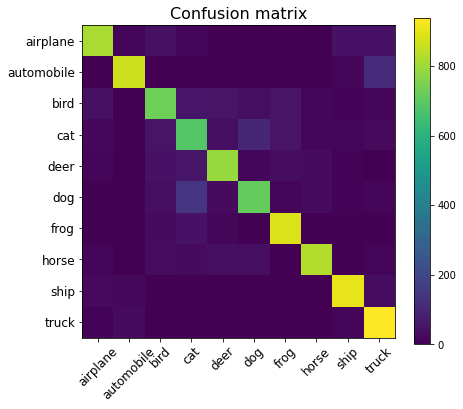

Test accuracy: 0.8168


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


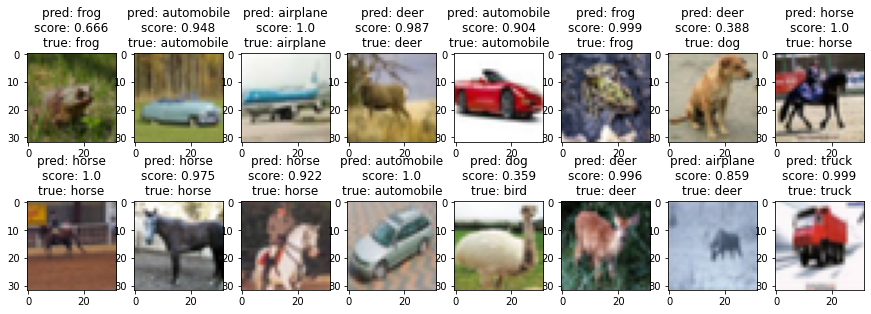

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights(model_path_weight)

# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

# Show the confusion matrix and accuracy
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(b=False)
        ax.axis(b=False)
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

##Experiment
The implementation for the experiment follows the steps below in the code given by the original problem description. Here we used the model of the above classifier c, and then used it to train the fake images generated from the generator, and finally used the fake labels and the fake images to train the classifier c'. The result shows that the acccuracy of the classifier c is 0.7919 and the accuracy of the classifier c' is 0.1. In the training process, the epoch was set to 200 in order to see if there's an improved result compared to epoch = 100. However, the results were not improved much and the potential reson is due to the training for the original classifier still need to be improved in oder to get a better result for the classifier c'. 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Number of epochs: 1
Number of batches: 128
epoch = 1/1, d_loss=0.000, g_loss=0.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


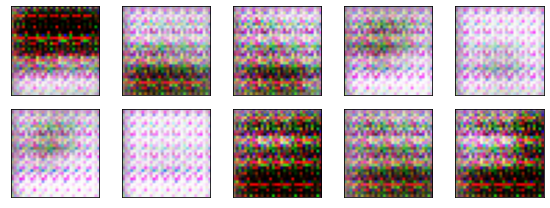

Time for epoch 1 is 746.4192497730255 sec


In [ ]:
# Step 1: Train a classifier C for CIFAR10 from scratch using (x_train, y_train)
# Step 2: Use x_train to train a GAN with latent dimension = 100 for 200 epochs
# Step 3: Generate 50,000 fake image samples
# Step 4: Use C to produce labels for all fake images
# Step 5: Train a classifier C' from scratch using the fake images and the predicted labels
# Step 6: Compare C and C' on (x_test, y_test)

#CIFAR10 data set contains 50k 32x32 images in the training set, and 10k images in the test set
num_imgs = 50000

# plot random generated fake images 
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(x_train[i])
plt.tight_layout()

# # reshape the training input and cast as float32
# print(f"x_train shape: {x_train.shape}, type: {type(x_train)}")

# normalize the training input
x_train = (np.float32(x_train)/255) - 0.5
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(num_imgs).batch(batch_size, drop_remainder=True)

# # get number of batches
# num_batch = num_imgs // batch_size

# define all the models
if os.path.isfile(model_gan_path) and os.path.isfile(model_g_path) and os.path.isfile(model_d_path):
  gan=keras.models.load_model(model_gan_path)
  generator=keras.models.load_model(model_g_path)
  discriminator=keras.models.load_model(model_d_path)
  gan.compile(keras.optimizers.Adam(learning_rate=3e-4, beta_1 = 0.85), loss='binary_crossentropy', metrics=['binary_accuracy'])
  opt = keras.optimizers.Adam(learning_rate=3e-5, beta_1 = 0.45)
  
  discriminator.compile(loss='binary_crossentropy',optimizer=opt,metrics=['binary_accuracy'])  
 
else:
  generator = define_generator()
  discriminator = define_discriminator()
  gan = define_gan(generator,discriminator)

#train the models
train(g_model=generator, d_model=discriminator, gan_model=gan, dataset=x_train, n_batch=batch_size)



In [ ]:
# Step 3: Generate 50,000 fake image samples
latent_dim = 100
num_imgs = 50000

# randomly generate 50000 training data set
random_noise = np.random.normal(size=(num_imgs,latent_dim))
random_img = generator.predict_on_batch(random_noise)
x_fake_train = random_img



# Step 4: Use c to produce labels for all fake images
# make test prediction
y_pred_test = model.predict_proba(x_fake_train)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)


#

# Step 5: Train a classifier c' from scratch using the fake images and the predicted labels
pred_label = y_pred_test_labels[:]
y_fake_train = pred_label
y_fake_train = np.reshape(y_fake_train,(50000,1))
x_fake_train  = [((x/255) - 0.5) for x in x_fake_train]
x_fake_train = np.array(x_fake_train)

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_fake_train)

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS =1

model1 = make_model()  # define our model


model1.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)
# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.95 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model1.optimizer.lr))


# we will save model checkpoints to continue training in case of kernel death
model_filename = 'fake_cifar.hdf5'
last_finished_epoch = None
print(f"x_test2: {len(x_test2)}")

# fit model
model1.fit(
    x_fake_train, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TqdmProgressCallback(),
               ModelSaveCallback(model_filename)],
    #validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

# save weights to file
model1.save_weights("fake_weights.h5")

# x_test for the original classifier c'
y__fake_pred_test = model1.predict_proba(x_test2)
y__fake_pred_test_classes = np.argmax(y__fake_pred_test, axis=1)
y__fake_pred_test_max_probas = np.max(y__fake_pred_test, axis=1)

# Step 6: Compare c and c' on (x_test, y_test)
print("c test accuracy:", accuracy_score(y_test[:], y_pred_test_classes))
print("c' test accuracy:", accuracy_score(y_test[:], y__fake_pred_test_classes))

x_test2: 10000
Learning rate: 0.005
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Model saved in fake_cifar.hdf5
c test accuracy: 0.8168
c' test accuracy: 0.1


## **Part 5: Visualize Class Activiation Map**

Using the code described in 

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb 

Implement the class activation map (CAM) to show the parts of the test images above that led your CNN to its final classification decision

In [ ]:
from keras.models import load_model

model = load_model(model_path)
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 16, 16, 32)      

Shape of the image: (32, 32, 3)


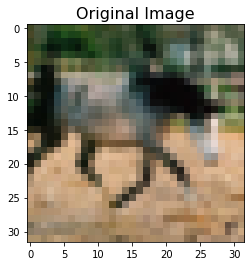

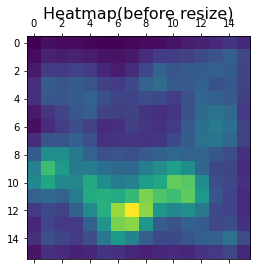

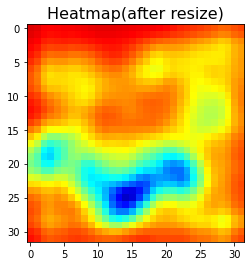

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


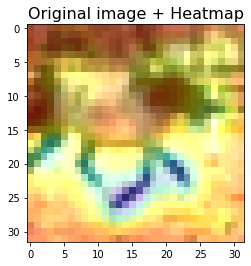

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Show a horse image x_train[52].
plt.imshow(x_train[52])
plt.title('Original Image', fontsize=16)

# Import the libraries
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2

# Pick a horse image x_train[52] to show the heatmap.
img = x_train[52]
print('Shape of the image:', np.shape(img))

# 'x' is a numpy array of shape (32, 32, 3)
x = image.img_to_array(img)

# A dimension was added to increse the "batch", the dimension of the array is now (1, 32, 32, 3)
x = np.expand_dims(x, axis=0)

# This is the "horse" entry in the prediction vector, 7 is the class of horse
horse = model.output[:, 7]

# This is the output feature map of the 'conv2d_16' layer,
# the last convolutional layer in our architecture
last_conv_layer = model.get_layer('conv2d_56')

# This is the gradient of the "horse" class with regard to
# the output feature map of 'conv2d_16'
grads = K.gradients(horse, last_conv_layer.output)[0]


# This is a vector of shape (64,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# 'pooled_grads' and the output feature map of 'conv2d_16', given a sample image.
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of one horse
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array by "how important this channel is" with regard to the horse class
for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis= -1)

heatmap = np.abs(heatmap)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.title('Heatmap(before resize)', fontsize=16)
plt.show()



# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
#print(np.shape(heatmap),'after resize')
plt.imshow(heatmap)
plt.title('Heatmap(after resize)', fontsize=16)
plt.show()
superimposed_img = heatmap * 0.4 + img

superimposed_img = superimposed_img.astype(int)

# Save the image to disk
plt.imshow(superimposed_img)
plt.title('Original image + Heatmap', fontsize=16)
plt.show()
